In [102]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [103]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [105]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 541, Edges: 35711

 Node types:
  default: [541]
    Features: float32 vector, length 500
    Edge types: default-default->default

 Edge types:
    default-default->default: [35711]
        Weights: range=[0.960001, 0.99577], mean=0.967045, std=0.00527737
        Features: none


In [270]:
# Splitting data into train/validation/test

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

series_classes = df_classes['class']
series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  378
Len validation:  81
Len test:  82

Len everything:  541


In [271]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'stage1': 169,
         'stage3': 76,
         'control': 50,
         'stage2': 34,
         'stage4': 49})

In [272]:
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))

array(['control', 'stage1', 'stage2', 'stage3', 'stage4'], dtype='<U7')

In [273]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.512     , 0.44733728, 2.22352941, 0.99473684, 1.54285714])

## The cell below is used to downsample the training data. Skip it if this is not the goal

In [123]:
# Testar downsample na train_subjects
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)

Counter({'stage1': 50,
         'stage2': 37,
         'stage3': 50,
         'stage4': 50,
         'control': 50})

In [274]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [275]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [278]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

nb_classes = 5
input_dim = df_features.loc[train_subjects.index].values.shape[1]

model = Sequential()
model.add(Dense(10, input_dim=input_dim))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=["acc"])

X_train = df_features.loc[train_subjects.index].values
y_train = train_targets

X_val = df_features.loc[val_subjects.index].values
y_val = val_targets

print("Training...")
model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=8, verbose=2)

Training...
Epoch 1/500
48/48 - 1s - loss: 1.9058 - acc: 0.3439 - val_loss: 1.3639 - val_acc: 0.4568
Epoch 2/500
48/48 - 0s - loss: 1.5145 - acc: 0.4418 - val_loss: 1.1282 - val_acc: 0.5926
Epoch 3/500
48/48 - 0s - loss: 1.3381 - acc: 0.5053 - val_loss: 1.0974 - val_acc: 0.5802
Epoch 4/500
48/48 - 0s - loss: 1.2814 - acc: 0.5053 - val_loss: 1.0814 - val_acc: 0.5926
Epoch 5/500
48/48 - 0s - loss: 1.2151 - acc: 0.5159 - val_loss: 1.1430 - val_acc: 0.5679
Epoch 6/500
48/48 - 0s - loss: 1.1691 - acc: 0.5132 - val_loss: 1.4312 - val_acc: 0.5802
Epoch 7/500
48/48 - 0s - loss: 1.0737 - acc: 0.5582 - val_loss: 1.1342 - val_acc: 0.5185
Epoch 8/500
48/48 - 0s - loss: 1.1302 - acc: 0.5450 - val_loss: 1.0139 - val_acc: 0.5802
Epoch 9/500
48/48 - 0s - loss: 1.1128 - acc: 0.5608 - val_loss: 1.0541 - val_acc: 0.5926
Epoch 10/500
48/48 - 0s - loss: 1.0806 - acc: 0.5688 - val_loss: 0.9885 - val_acc: 0.5679
Epoch 11/500
48/48 - 0s - loss: 1.0287 - acc: 0.6032 - val_loss: 1.1361 - val_acc: 0.5309
Epoch 1

Epoch 92/500
48/48 - 0s - loss: 0.3234 - acc: 0.8968 - val_loss: 1.3614 - val_acc: 0.5926
Epoch 93/500
48/48 - 0s - loss: 0.3690 - acc: 0.8704 - val_loss: 1.5651 - val_acc: 0.6296
Epoch 94/500
48/48 - 0s - loss: 0.3456 - acc: 0.8810 - val_loss: 2.4926 - val_acc: 0.5802
Epoch 95/500
48/48 - 0s - loss: 0.3625 - acc: 0.8730 - val_loss: 1.6918 - val_acc: 0.6049
Epoch 96/500
48/48 - 0s - loss: 0.3720 - acc: 0.8571 - val_loss: 1.5218 - val_acc: 0.6173
Epoch 97/500
48/48 - 0s - loss: 0.3338 - acc: 0.8704 - val_loss: 1.8708 - val_acc: 0.6173
Epoch 98/500
48/48 - 0s - loss: 0.2827 - acc: 0.9021 - val_loss: 1.8155 - val_acc: 0.5926
Epoch 99/500
48/48 - 0s - loss: 0.3344 - acc: 0.8836 - val_loss: 1.7417 - val_acc: 0.5802
Epoch 100/500
48/48 - 0s - loss: 0.3149 - acc: 0.8783 - val_loss: 1.6753 - val_acc: 0.6173
Epoch 101/500
48/48 - 0s - loss: 0.4689 - acc: 0.8677 - val_loss: 1.6057 - val_acc: 0.6049
Epoch 102/500
48/48 - 0s - loss: 0.3021 - acc: 0.8995 - val_loss: 1.6203 - val_acc: 0.6049
Epoch 1

Epoch 183/500
48/48 - 0s - loss: 0.2075 - acc: 0.9233 - val_loss: 3.6456 - val_acc: 0.5802
Epoch 184/500
48/48 - 0s - loss: 0.1947 - acc: 0.9365 - val_loss: 2.2537 - val_acc: 0.6296
Epoch 185/500
48/48 - 0s - loss: 0.1691 - acc: 0.9339 - val_loss: 2.5317 - val_acc: 0.5926
Epoch 186/500
48/48 - 0s - loss: 0.2151 - acc: 0.9206 - val_loss: 2.1170 - val_acc: 0.6543
Epoch 187/500
48/48 - 0s - loss: 0.2272 - acc: 0.9418 - val_loss: 2.0946 - val_acc: 0.6173
Epoch 188/500
48/48 - 0s - loss: 0.1864 - acc: 0.9312 - val_loss: 5.1944 - val_acc: 0.5556
Epoch 189/500
48/48 - 0s - loss: 0.2546 - acc: 0.9286 - val_loss: 2.4849 - val_acc: 0.6420
Epoch 190/500
48/48 - 0s - loss: 0.1415 - acc: 0.9577 - val_loss: 2.3365 - val_acc: 0.5802
Epoch 191/500
48/48 - 0s - loss: 0.1911 - acc: 0.9339 - val_loss: 2.3724 - val_acc: 0.6296
Epoch 192/500
48/48 - 0s - loss: 0.1994 - acc: 0.9365 - val_loss: 2.1356 - val_acc: 0.6296
Epoch 193/500
48/48 - 0s - loss: 0.2038 - acc: 0.9365 - val_loss: 2.3156 - val_acc: 0.6173

48/48 - 0s - loss: 0.1392 - acc: 0.9418 - val_loss: 3.1236 - val_acc: 0.6296
Epoch 274/500
48/48 - 0s - loss: 0.1356 - acc: 0.9524 - val_loss: 2.5009 - val_acc: 0.6420
Epoch 275/500
48/48 - 0s - loss: 0.1454 - acc: 0.9524 - val_loss: 2.5829 - val_acc: 0.6173
Epoch 276/500
48/48 - 0s - loss: 0.1292 - acc: 0.9471 - val_loss: 2.4411 - val_acc: 0.6296
Epoch 277/500
48/48 - 0s - loss: 0.1836 - acc: 0.9418 - val_loss: 2.6385 - val_acc: 0.6296
Epoch 278/500
48/48 - 0s - loss: 0.0900 - acc: 0.9683 - val_loss: 3.1452 - val_acc: 0.5679
Epoch 279/500
48/48 - 0s - loss: 0.1234 - acc: 0.9603 - val_loss: 2.5218 - val_acc: 0.6296
Epoch 280/500
48/48 - 0s - loss: 0.2110 - acc: 0.9392 - val_loss: 2.5662 - val_acc: 0.6049
Epoch 281/500
48/48 - 0s - loss: 0.1411 - acc: 0.9497 - val_loss: 2.3308 - val_acc: 0.6173
Epoch 282/500
48/48 - 0s - loss: 0.1676 - acc: 0.9471 - val_loss: 2.7086 - val_acc: 0.6049
Epoch 283/500
48/48 - 0s - loss: 0.1660 - acc: 0.9392 - val_loss: 2.9134 - val_acc: 0.6296
Epoch 284/500

Epoch 364/500
48/48 - 0s - loss: 0.1781 - acc: 0.9418 - val_loss: 2.5085 - val_acc: 0.6049
Epoch 365/500
48/48 - 0s - loss: 0.0679 - acc: 0.9735 - val_loss: 3.3305 - val_acc: 0.6173
Epoch 366/500
48/48 - 0s - loss: 0.1972 - acc: 0.9524 - val_loss: 2.2221 - val_acc: 0.6049
Epoch 367/500
48/48 - 0s - loss: 0.1630 - acc: 0.9524 - val_loss: 2.8123 - val_acc: 0.6049
Epoch 368/500
48/48 - 0s - loss: 0.1296 - acc: 0.9577 - val_loss: 2.3692 - val_acc: 0.6049
Epoch 369/500
48/48 - 0s - loss: 0.1282 - acc: 0.9603 - val_loss: 2.8006 - val_acc: 0.6296
Epoch 370/500
48/48 - 0s - loss: 0.1690 - acc: 0.9365 - val_loss: 2.6970 - val_acc: 0.6173
Epoch 371/500
48/48 - 0s - loss: 0.1174 - acc: 0.9577 - val_loss: 3.0844 - val_acc: 0.6667
Epoch 372/500
48/48 - 0s - loss: 0.1761 - acc: 0.9365 - val_loss: 2.7625 - val_acc: 0.6420
Epoch 373/500
48/48 - 0s - loss: 0.1069 - acc: 0.9577 - val_loss: 3.2246 - val_acc: 0.6296
Epoch 374/500
48/48 - 0s - loss: 0.1042 - acc: 0.9709 - val_loss: 2.5851 - val_acc: 0.6173

Epoch 455/500
48/48 - 0s - loss: 0.1517 - acc: 0.9603 - val_loss: 3.0231 - val_acc: 0.6296
Epoch 456/500
48/48 - 0s - loss: 0.0734 - acc: 0.9868 - val_loss: 3.4737 - val_acc: 0.6667
Epoch 457/500
48/48 - 0s - loss: 0.1561 - acc: 0.9418 - val_loss: 3.0786 - val_acc: 0.6543
Epoch 458/500
48/48 - 0s - loss: 0.1195 - acc: 0.9603 - val_loss: 3.1878 - val_acc: 0.6420
Epoch 459/500
48/48 - 0s - loss: 0.1227 - acc: 0.9471 - val_loss: 3.1649 - val_acc: 0.6173
Epoch 460/500
48/48 - 0s - loss: 0.2699 - acc: 0.9259 - val_loss: 2.6695 - val_acc: 0.5802
Epoch 461/500
48/48 - 0s - loss: 0.1697 - acc: 0.9603 - val_loss: 2.8556 - val_acc: 0.6420
Epoch 462/500
48/48 - 0s - loss: 0.0915 - acc: 0.9683 - val_loss: 3.7256 - val_acc: 0.6296
Epoch 463/500
48/48 - 0s - loss: 0.1299 - acc: 0.9603 - val_loss: 2.8611 - val_acc: 0.6296
Epoch 464/500
48/48 - 0s - loss: 0.1755 - acc: 0.9312 - val_loss: 3.3954 - val_acc: 0.6296
Epoch 465/500
48/48 - 0s - loss: 0.1188 - acc: 0.9630 - val_loss: 3.7851 - val_acc: 0.6790

In [279]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64, float32
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_true = cast(y_true, dtype=float32)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [280]:
gat = GAT(
    layer_sizes=[100, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.1,
    attn_dropout=0.1,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [282]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
    loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(weights),#weights/(max(weights)+1)),#np.array([1,1,1,1,1])),#weights),
    metrics=["acc"],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [283]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [284]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 2s - loss: 8.8154 - acc: 0.0873 - val_loss: 7.0480 - val_acc: 0.4321
Epoch 2/500
1/1 - 0s - loss: 7.3671 - acc: 0.4418 - val_loss: 6.6910 - val_acc: 0.4198
Epoch 3/500
1/1 - 0s - loss: 6.8560 - acc: 0.4286 - val_loss: 5.4407 - val_acc: 0.4198
Epoch 4/500
1/1 - 0s - loss: 6.1724 - acc: 0.4074 - val_loss: 3.8747 - val_acc: 0.5556
Epoch 5/500
1/1 - 0s - loss: 5.0351 - acc: 0.4603 - val_loss: 2.6712 - val_acc: 0.5679
Epoch 6/500
1/1 - 0s - loss: 3.5987 - acc: 0.5159 - val_loss: 3.2969 - val_acc: 0.3210
Epoch 7/500
1/1 - 0s - loss: 4.2954 - acc: 0.2884 - val_loss: 4.0805 - val_acc: 0.3210
Epoch 8/500
1/1 - 0s - loss: 3.8260 - acc: 0.2381 - val_loss: 4.5060 - val_acc: 0.3333
Epoch 9/500
1/1 - 0s - loss: 4.2002 - acc: 0.3360 - val_loss: 4.0364 - val_acc: 0.3333
Epoch 10/500
1/1 - 0s - loss: 3.9277 - acc: 0.2857 - val_loss: 3.0314 - val_acc: 0.3210
Epoch 11/500
1/1 - 0s - loss: 2.9763 - acc: 0.5159 - val_loss: 2.2762 - val_acc: 0.5062
Epoch 12/500
1/1 - 0s - loss: 2.8799 - ac

Epoch 95/500
1/1 - 0s - loss: 1.6721 - acc: 0.3942 - val_loss: 1.4178 - val_acc: 0.3333
Epoch 96/500
1/1 - 0s - loss: 1.7902 - acc: 0.3413 - val_loss: 1.3243 - val_acc: 0.3457
Epoch 97/500
1/1 - 0s - loss: 1.6528 - acc: 0.4392 - val_loss: 1.1567 - val_acc: 0.5679
Epoch 98/500
1/1 - 0s - loss: 1.3730 - acc: 0.5794 - val_loss: 1.1605 - val_acc: 0.5926
Epoch 99/500
1/1 - 0s - loss: 1.6503 - acc: 0.5794 - val_loss: 1.2773 - val_acc: 0.5802
Epoch 100/500
1/1 - 0s - loss: 1.6301 - acc: 0.5767 - val_loss: 1.3796 - val_acc: 0.5679
Epoch 101/500
1/1 - 0s - loss: 1.9705 - acc: 0.5767 - val_loss: 1.3500 - val_acc: 0.5802
Epoch 102/500
1/1 - 0s - loss: 1.5160 - acc: 0.5767 - val_loss: 1.2578 - val_acc: 0.5802
Epoch 103/500
1/1 - 0s - loss: 1.6646 - acc: 0.5820 - val_loss: 1.1578 - val_acc: 0.5926
Epoch 104/500
1/1 - 0s - loss: 1.5770 - acc: 0.5794 - val_loss: 1.2062 - val_acc: 0.4938
Epoch 105/500
1/1 - 0s - loss: 1.5018 - acc: 0.5556 - val_loss: 1.4533 - val_acc: 0.3333
Epoch 106/500
1/1 - 0s - l

1/1 - 0s - loss: 1.2297 - acc: 0.5820 - val_loss: 1.2218 - val_acc: 0.3951
Epoch 188/500
1/1 - 0s - loss: 1.2134 - acc: 0.5767 - val_loss: 1.1991 - val_acc: 0.4568
Epoch 189/500
1/1 - 0s - loss: 1.6785 - acc: 0.3915 - val_loss: 1.1399 - val_acc: 0.6049
Epoch 190/500
1/1 - 0s - loss: 1.5387 - acc: 0.4762 - val_loss: 1.2159 - val_acc: 0.6049
Epoch 191/500
1/1 - 0s - loss: 1.5420 - acc: 0.6005 - val_loss: 1.3126 - val_acc: 0.5802
Epoch 192/500
1/1 - 0s - loss: 1.7720 - acc: 0.5635 - val_loss: 1.2988 - val_acc: 0.5802
Epoch 193/500
1/1 - 0s - loss: 1.6798 - acc: 0.5979 - val_loss: 1.2084 - val_acc: 0.5679
Epoch 194/500
1/1 - 0s - loss: 1.5802 - acc: 0.5926 - val_loss: 1.0843 - val_acc: 0.6049
Epoch 195/500
1/1 - 0s - loss: 1.4708 - acc: 0.5767 - val_loss: 1.0594 - val_acc: 0.6049
Epoch 196/500
1/1 - 0s - loss: 1.2972 - acc: 0.5873 - val_loss: 1.1108 - val_acc: 0.4938
Epoch 197/500
1/1 - 0s - loss: 1.3458 - acc: 0.5899 - val_loss: 1.1864 - val_acc: 0.4074
Epoch 198/500
1/1 - 0s - loss: 1.67

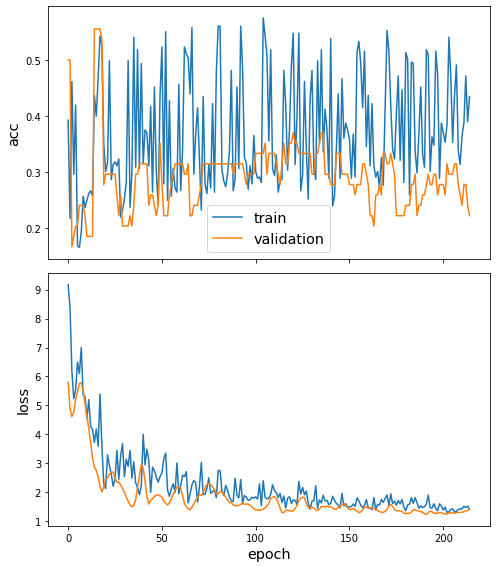

In [234]:
sg.utils.plot_history(history)

In [235]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 63ms/step - loss: 2.6301 - acc: 0.5122

Test Set Metrics:
	loss: 2.6301
	acc: 0.5122


In [236]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [237]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})
df['Predicted'].value_counts()

stage1     335
control    104
stage4      95
stage2       7
Name: Predicted, dtype: int64

In [120]:
G.check_graph_for_ml()

In [121]:
for component in G.connected_components():
    print(len(component))

530
3
2
2
2
2


In [122]:
G.node_degrees()

defaultdict(int,
            {'TCGA.3Z.A93Z.01': 171,
             'TCGA.A3.3306.01': 8,
             'TCGA.A3.3307.01': 281,
             'TCGA.A3.3308.01': 132,
             'TCGA.A3.3311.01': 302,
             'TCGA.A3.3316.01': 54,
             'TCGA.A3.3317.01': 50,
             'TCGA.A3.3319.01': 1,
             'TCGA.A3.3320.01': 206,
             'TCGA.A3.3322.01': 221,
             'TCGA.A3.3323.01': 156,
             'TCGA.A3.3324.01': 249,
             'TCGA.A3.3325.01': 262,
             'TCGA.A3.3326.01': 225,
             'TCGA.A3.3329.01': 262,
             'TCGA.A3.3331.01': 256,
             'TCGA.A3.3335.01': 18,
             'TCGA.A3.3343.01': 243,
             'TCGA.A3.3347.01': 31,
             'TCGA.A3.3349.01': 250,
             'TCGA.A3.3351.01': 182,
             'TCGA.A3.3352.01': 206,
             'TCGA.A3.3357.01': 51,
             'TCGA.A3.3358.11': 42,
             'TCGA.A3.3358.01': 277,
             'TCGA.A3.3359.01': 246,
             'TCGA.A3.3362.01':

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

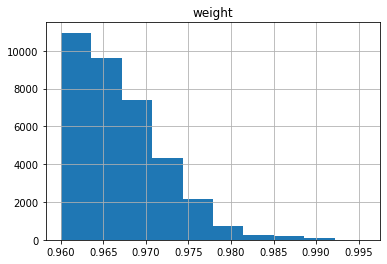

In [100]:
df_patients.hist(column='weight')

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

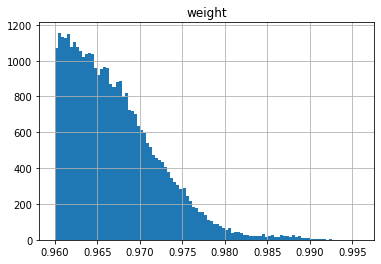

In [101]:
df_patients.hist(column='weight', bins=100)

<AxesSubplot:ylabel='Density'>

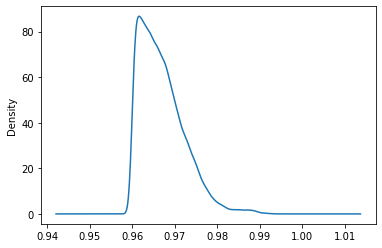

In [102]:
df_patients['weight'].plot.kde()